In [8]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

from tqdm.notebook import tqdm

from geoid.censusnames import stusab
import rowgenerators as rg

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [26]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()
pkg

# Tract Income Distributions
`civicknowledge.com-income_dist-tract-1.1.1` Last Update: 2021-02-19T04:02:37

_Estimated portions of households per tracts in income ranges_




 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [tract_income_dist](notebooks/Extract.ipynb)**. Estimated portions of households per tracts in income ranges

## References
<ul><li> <strong>pums</string>, <em>pums:{st}/h/2019/5</em>. PUMS template</li><li> <strong>us_tracts</string>, <em>metapack+http://library.metatab.org/civicknowledge.com-geohash-us.csv#us_tracts</em>. US Tracts, with tract numbers</li><li> <strong>households</string>, <em>census://2019/5/US/tract/B11001</em>. US Households by tract</li><li> <strong>median_income</string>, <em>census://2019/5/US/tract/B19013</em>. US Household median income by tract</li><ul>

'pums:{st}/h/2019/5'

In [16]:
frames = [rg.dataframe(pkg.reference('pums').url.format(st=st), low_memory=False) for st in tqdm(list(stusab.values()))]
pums = pd.concat(frames)

  0%|          | 0/52 [00:00<?, ?it/s]

In [17]:
%time hh = pkg.reference('households').dataframe().rename(columns={'b11001_001':'households'})
hh = hh[['households']].copy()

CPU times: user 27.8 s, sys: 708 ms, total: 28.5 s
Wall time: 29 s


In [18]:
%time mi = pkg.reference('median_income').dataframe().rename(columns={'b19013_001':'median_income'})
mi = mi[['median_income']].copy()
mi

CPU times: user 21.6 s, sys: 522 ms, total: 22.1 s
Wall time: 22.4 s


,median_income
geoid,
14000US01001020100,60208.0
14000US01001020200,43958.0
14000US01001020300,55345.0
14000US01001020400,59663.0
14000US01001020500,66108.0
...,...
14000US72153750501,20221.0
14000US72153750502,18871.0
14000US72153750503,13699.0


In [215]:
t = pums[['PUMA','HINCP', 'WGTP']].dropna()
t = t.sample(int(20e6), replace=True, weights=t.WGTP)

In [216]:
step = 5_000

t['hnincc'] = t.HINCP.clip(-step, 500_000)
t['medinc'] = t.groupby('PUMA').hnincc.transform(lambda g: (g.median()/10e3).round()).astype(int)
t.head()

,PUMA,HINCP,WGTP,hnincc,medinc
98216,1300,81500.0,21,81500.0,5
221244,2515,85000.0,20,85000.0,6
14428,4626,27000.0,78,27000.0,4
23120,41004,80500.0,62,80500.0,4
24903,5904,40000.0,17,40000.0,7


In [217]:
inc_bins = np.arange(-step, t.hnincc.max()+step, step)
t['incc'] = pd.cut(t.HINCP, inc_bins).apply(lambda e: e.left)
t.head()

,PUMA,HINCP,WGTP,hnincc,medinc,incc
98216,1300,81500.0,21,81500.0,5,80000.0
221244,2515,85000.0,20,85000.0,6,80000.0
14428,4626,27000.0,78,27000.0,4,25000.0
23120,41004,80500.0,62,80500.0,4,80000.0
24903,5904,40000.0,17,40000.0,7,35000.0


In [218]:
inc_bins

array([ -5000.,      0.,   5000.,  10000.,  15000.,  20000.,  25000.,
        30000.,  35000.,  40000.,  45000.,  50000.,  55000.,  60000.,
        65000.,  70000.,  75000.,  80000.,  85000.,  90000.,  95000.,
       100000., 105000., 110000., 115000., 120000., 125000., 130000.,
       135000., 140000., 145000., 150000., 155000., 160000., 165000.,
       170000., 175000., 180000., 185000., 190000., 195000., 200000.,
       205000., 210000., 215000., 220000., 225000., 230000., 235000.,
       240000., 245000., 250000., 255000., 260000., 265000., 270000.,
       275000., 280000., 285000., 290000., 295000., 300000., 305000.,
       310000., 315000., 320000., 325000., 330000., 335000., 340000.,
       345000., 350000., 355000., 360000., 365000., 370000., 375000.,
       380000., 385000., 390000., 395000., 400000., 405000., 410000.,
       415000., 420000., 425000., 430000., 435000., 440000., 445000.,
       450000., 455000., 460000., 465000., 470000., 475000., 480000.,
       485000., 4900

In [219]:
medinc_bins = t.groupby('medinc').incc.value_counts().unstack().fillna(0)
medinc_bins = medinc_bins.divide(t.groupby('medinc').incc.count(), axis=0)
medinc_bins.columns = list(medinc_bins.columns)

medinc_bins

,-5000.0,0.0,5000.0,10000.0,15000.0,20000.0,25000.0,30000.0,35000.0,40000.0,...,450000.0,455000.0,460000.0,465000.0,470000.0,475000.0,480000.0,485000.0,490000.0,495000.0
medinc,,,,,,,,,,,,,,,,,,,,,
2,0.046230,0.057026,0.123890,0.112833,0.085582,0.075570,0.069737,0.068170,0.054936,0.040484,...,0.000000,0.000000,0.000000,0.000174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000087
3,0.035942,0.041898,0.091729,0.089533,0.085913,0.075959,0.067120,0.055258,0.053490,0.042630,...,0.000107,0.000084,0.000281,0.000186,0.000141,0.000146,0.000118,0.000152,0.000084,0.000051
4,0.025051,0.029761,0.060089,0.072932,0.068597,0.066706,0.062386,0.055135,0.056876,0.047217,...,0.000166,0.000212,0.000183,0.000242,0.000184,0.000194,0.000189,0.000112,0.000232,0.000162
5,0.015887,0.022701,0.041681,0.055544,0.056031,0.055527,0.055044,0.050148,0.052045,0.045324,...,0.000272,0.000242,0.000230,0.000240,0.000219,0.000280,0.000244,0.000210,0.000194,0.000202
6,0.014144,0.019902,0.033539,0.044786,0.046776,0.047737,0.048178,0.044332,0.047231,0.041357,...,0.000352,0.000311,0.000348,0.000388,0.000372,0.000396,0.000393,0.000316,0.000322,0.000350
7,0.012338,0.016791,0.026089,0.035671,0.038601,0.040299,0.041765,0.038824,0.042524,0.037785,...,0.000526,0.000424,0.000492,0.000598,0.000481,0.000557,0.000656,0.000517,0.000557,0.000568
8,0.011496,0.014549,0.020500,0.029968,0.032448,0.034267,0.034846,0.033863,0.037653,0.033688,...,0.000540,0.000560,0.000589,0.000669,0.000580,0.000676,0.000780,0.000569,0.000611,0.000639
9,0.009921,0.012562,0.016594,0.024052,0.026136,0.028547,0.030506,0.028701,0.032731,0.029766,...,0.000891,0.000510,0.000970,0.000986,0.000826,0.000671,0.001176,0.000737,0.000872,0.000726
10,0.009815,0.011039,0.015101,0.021934,0.024280,0.023826,0.026408,0.026711,0.028308,0.027672,...,0.001131,0.000720,0.000973,0.001250,0.000743,0.000848,0.001163,0.000825,0.001375,0.001040


In [220]:
x = medinc_bins.copy()
rows = []

def _f(r):
    try:
        return pd.Series(list(x.columns)).sample(100000,replace=True, weights=list(r)).median()
    except:
        return np.nan

cmed = x.apply(_f, axis=1)
cmed

medinc
2      20000.0
3      30000.0
4      40000.0
5      50000.0
6      55000.0
7      65000.0
8      75000.0
9      85000.0
10     95000.0
11    100000.0
12    110000.0
13    115000.0
14    125000.0
15    130000.0
17    150000.0
dtype: float64

<AxesSubplot:>

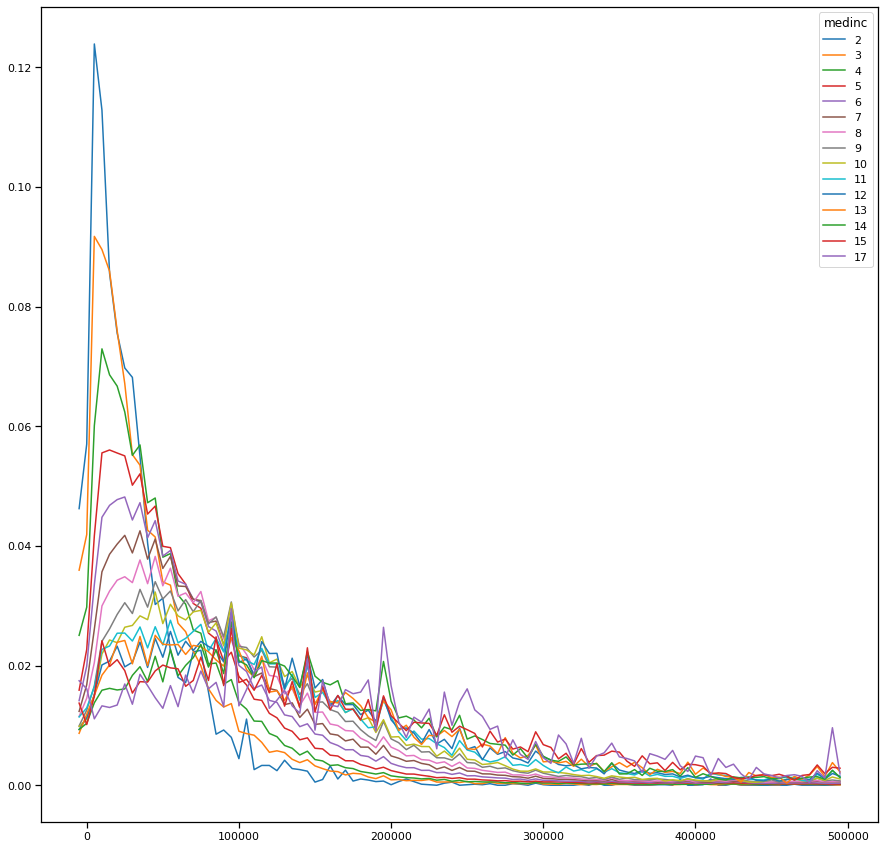

In [221]:
medinc_bins.T.plot(figsize=(15, 15) )

In [424]:
mi['medinc'] = (mi.median_income/10e3).clip(medinc_bins.index.min(), medinc_bins.index.max()).round().fillna(0).astype(int)
t = mi[['medinc','median_income']].join(hh).reset_index().merge(medinc_bins.reset_index()).set_index('geoid')
t.iloc[:,3:]= t.iloc[:,3:].multiply(t.households, axis=0)

t.fillna(0).to_csv('income_counts.csv')

tracts = pkg.reference('us_tracts').dataframe()

tract_income_dist = tracts[['geoid','tract_id']].set_index('geoid').join(t)#.drop(columns=['medinc','households'])
tract_income_dist.insert(0,'offset',0)

In [425]:
tract_income_dist.head()

,offset,tract_id,medinc,median_income,households,-5000.0,0.0,5000.0,10000.0,15000.0,...,450000.0,455000.0,460000.0,465000.0,470000.0,475000.0,480000.0,485000.0,490000.0,495000.0
geoid,,,,,,,,,,,,,,,,,,,,,
14000US01055010700,0,0,5.0,46078.0,1376.0,21.861079,31.236507,57.352581,76.428040,77.098681,...,0.374503,0.332663,0.315858,0.329919,0.301283,0.385477,0.335063,0.289451,0.267502,0.278476
14000US01055001300,0,1,2.0,22946.0,1092.0,50.483371,62.272332,135.287829,123.213651,93.456033,...,0.000000,0.000000,0.000000,0.190145,0.000000,0.000000,0.000000,0.000000,0.000000,0.095072
14000US01055000900,0,2,3.0,30238.0,898.0,32.275643,37.624583,82.372659,80.400932,77.150112,...,0.096058,0.075836,0.252785,0.166838,0.126393,0.131448,0.106170,0.136504,0.075836,0.045501
14000US01055001700,0,3,2.0,24462.0,684.0,31.621452,39.005746,84.740728,77.177782,58.538395,...,0.000000,0.000000,0.000000,0.119102,0.000000,0.000000,0.000000,0.000000,0.000000,0.059551
14000US01055010501,0,4,7.0,73248.0,3200.0,39.481193,53.731962,83.485990,114.147809,123.524371,...,1.682186,1.357553,1.575942,1.912380,1.540528,1.783707,2.097715,1.653854,1.783707,1.817941


# Test The Error

Re-calculate the media income from the distribution, then compare to the actual value. It's off by a lot, about 8K. 

In [432]:
cmed = tract_income_dist.apply(_f, axis=1).fillna(0)
z = cmed.to_frame('calc').join(tract_income_dist)
z['dx'] = (z.calc-z.median_income)
np.sqrt(np.sum(np.square(np.abs(z.dx)))/len(z))

9110.812317610793

To try to correct the errors, we can shift the weights up or down. 

In [427]:
def roll(index, weights, n):
    n = int(n)
    if n > 0:
        return index, [weights[0]]*n +weights[:-n]
    else:
        return index,  weights[-n:]+[weights[-1]]*-n

rows = []

def _f(r):
    try:
        t = r.loc[-5000:]
        
        index, weights = roll(list(t.index),list(t), r['offset'])
        
        return pd.Series(index).sample(10000,replace=True, weights=weights).median()
    except:
        return np.nan

r=tract_income_dist.iloc[0]
r.offset=-1
_f(r)

45000.0

In [428]:
def _f_offset(v):
    try:
        return int(v/2000)
    except ValueError:
        return v

x['offset'] = -z.dx.apply(_f_offset)
cmed = x.apply(_f, axis=1).fillna(0)

z = cmed.to_frame('calc').join(tract_income_dist)
z['dx'] = (z.calc-z.median_income)
np.sqrt(np.sum(np.square(np.abs(z.dx)))/len(z))

5219.1994052919645

In [430]:
x.loc[:,-5000:].sum(axis=1)


geoid
14000US53033020800    1748.0
14000US50025967700    1012.0
14000US55021970500    1863.0
14000US17099962900    1210.0
14000US36085015601    2399.0
                       ...  
14000US17031815500    2433.0
14000US06037920045    1342.0
14000US05107480200    2141.0
14000US08075966100    2979.0
14000US47029920502    2228.0
Length: 5000, dtype: float64

In [431]:
x

,offset,tract_id,medinc,median_income,households,-5000.0,0.0,5000.0,10000.0,15000.0,...,450000.0,455000.0,460000.0,465000.0,470000.0,475000.0,480000.0,485000.0,490000.0,495000.0
geoid,,,,,,,,,,,,,,,,,,,,,
14000US53033020800,3.0,70160,12.0,116563.0,1748.0,16.263844,19.762527,26.502801,35.143318,36.272285,...,1.956132,1.196035,1.665507,1.821998,1.989666,1.676685,3.532216,1.799642,3.431615,2.649162
14000US50025967700,3.0,67585,5.0,51818.0,1012.0,16.078061,22.973361,42.180823,56.210157,56.703390,...,0.275434,0.244662,0.232303,0.242644,0.221583,0.283505,0.246427,0.212881,0.196738,0.204810
14000US55021970500,-0.0,72713,5.0,49926.0,1863.0,29.598249,42.291870,77.651061,103.477790,104.385787,...,0.507048,0.450400,0.427648,0.446685,0.407914,0.521907,0.453650,0.391894,0.362177,0.377036
14000US17099962900,-2.0,21377,5.0,45455.0,1210.0,19.223769,27.468149,50.433593,67.207797,67.797532,...,0.329323,0.292530,0.277753,0.290118,0.264936,0.338973,0.294641,0.254532,0.235231,0.244881
14000US36085015601,2.0,44466,11.0,105344.0,2399.0,27.389856,31.026991,39.427041,54.445688,55.831264,...,2.993832,3.092802,3.092802,3.129916,1.967022,1.558772,4.379408,2.919605,5.876324,3.055688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14000US17031815500,2.0,22605,7.0,70917.0,2433.0,30.018045,40.853082,63.475442,86.788006,93.917123,...,1.278987,1.032165,1.198209,1.454006,1.171283,1.356175,1.594919,1.257446,1.356175,1.382203
14000US06037920045,8.0,6988,14.0,141029.0,1342.0,12.511126,13.888498,18.498867,21.311001,21.731864,...,1.473022,1.473022,2.085188,1.224330,1.587803,1.836496,1.932146,1.339111,3.347778,1.759975
14000US05107480200,3.0,3473,4.0,41736.0,2141.0,53.634921,63.717761,128.650077,156.148321,146.866137,...,0.355093,0.454610,0.391281,0.517939,0.393543,0.416160,0.404852,0.239745,0.497583,0.346046


In [ ]:
0